In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

import anndata
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import seaborn as sns
import torch
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from scipy.stats import pearsonr

In [3]:
from spaceoracle.models.estimators import ViTEstimatorV2

In [36]:
from spaceoracle.callbacks.simulation_callback import SimulationBetaCallbackV2
from spaceoracle.callbacks.fixtures.simulator import SimulatedDataV2

In [39]:
# Simulated data pt1

sim_data = SimulatedDataV2(density=20, ntfs=20, clusters=6)

cmap = mcolors.ListedColormap(plt.cm.get_cmap('tab10', sim_data.clusters).colors)
scatter = plt.scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.labels, cmap=cmap, s=10, alpha=0.7)

plt.colorbar(scatter, label="Cluster")
plt.title('Cell locations by cluster')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


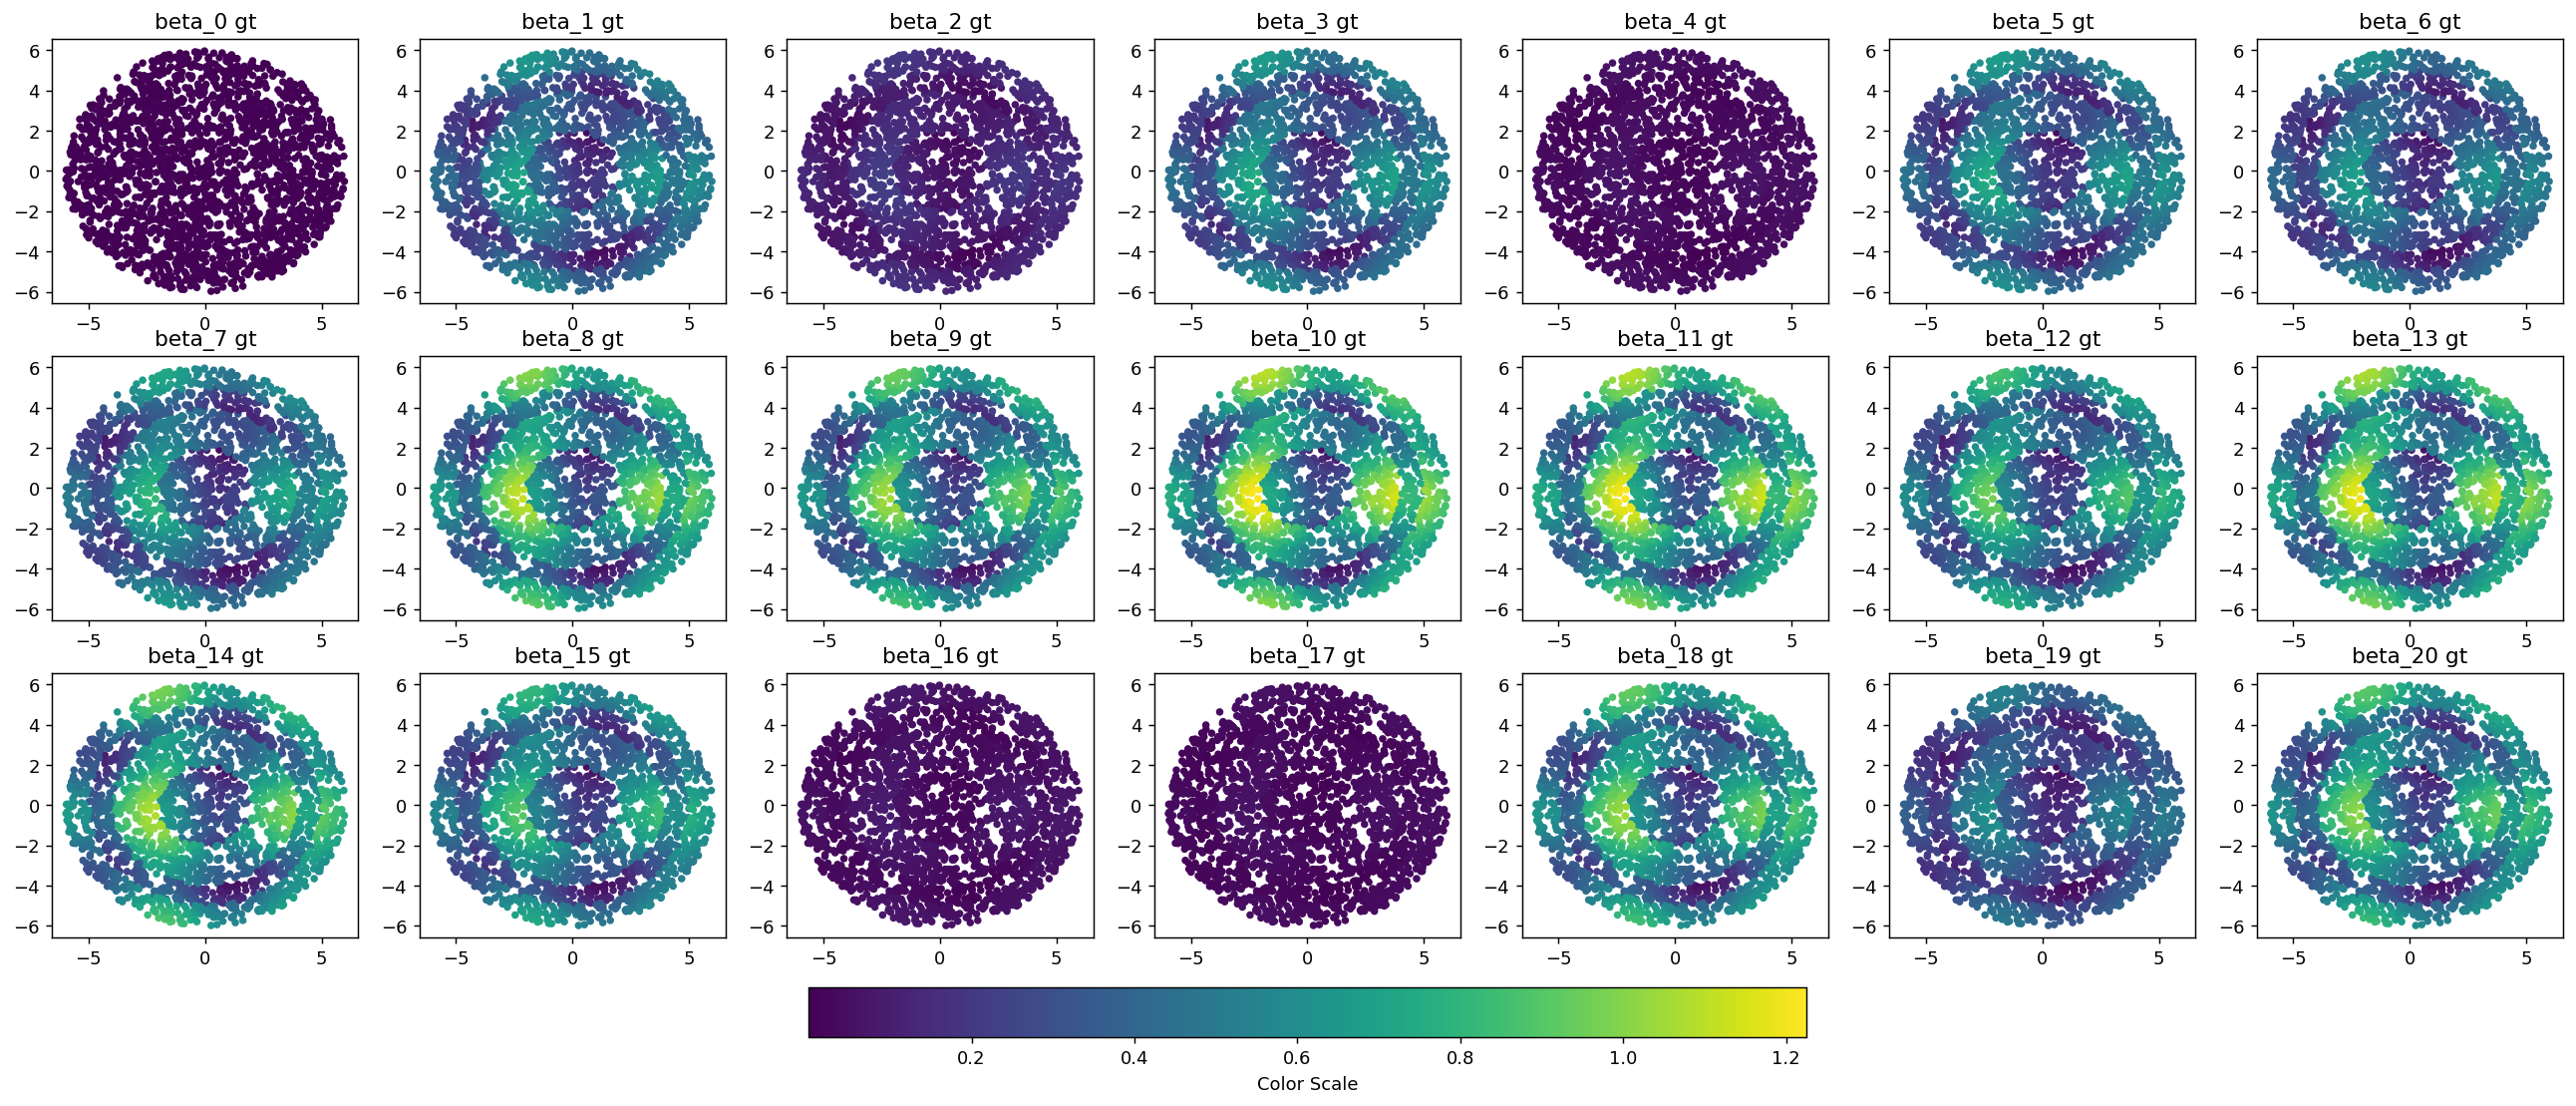

In [40]:
fig, axes = plt.subplots(3, 7, figsize=(25, 10)) 
axes = axes.flatten()

vmin = np.min(sim_data.betas)
vmax = np.max(sim_data.betas)

for i, beta in enumerate(range(sim_data.ntfs + 1)):
    sc = axes[i].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.betas[:, beta], vmin=vmin, vmax=vmax, s=10)
    axes[i].set_title(f"beta_{beta} gt")

cbar = fig.colorbar(sc, ax=axes, orientation='horizontal', fraction=0.05, pad=0.05)
cbar.set_label('Color Scale')

plt.show()


[cuda] MSE: 0.0151 | Baseline: 2.3081: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]

Best model at 17/20


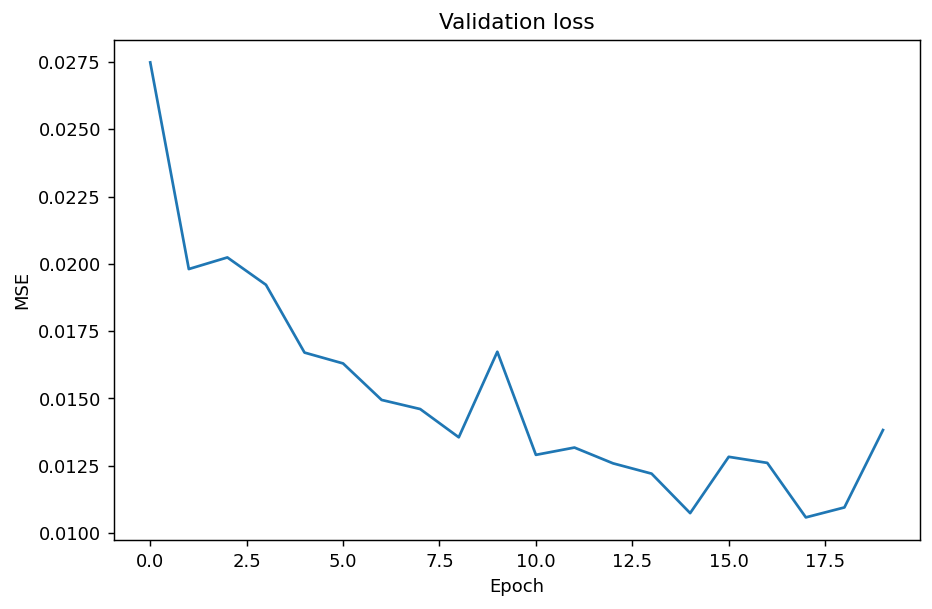

In [41]:
estimator = ViTEstimatorV2(sim_data.adata, target_gene='target_gene', 
                        regulators=sim_data.tf_labels, n_clusters=sim_data.clusters)
                        
estimator.fit(
    annot='sim_cluster', 
    max_epochs=20, 
    learning_rate=0.01, 
    spatial_dim=64,
    batch_size=32,
    init_betas='ones',
    mode='train_test',
    rotate_maps=True,
    regularize=False,
    n_patches=16, n_heads=2, n_blocks=2, hidden_d=16
)

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams['figure.dpi'] = 130
plt.plot(estimator.losses)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Validation loss')
plt.show()

In [42]:
check_betas = SimulationBetaCallbackV2()

with torch.no_grad():
    beta_pred = estimator.get_betas(
        np.array(sim_data.adata.obsm['spatial']),
        np.array(sim_data.adata.obs['sim_cluster']),
    )

    y_pred = estimator.predict_y(
        estimator.model, 
        torch.from_numpy(beta_pred).cuda(), 
        torch.from_numpy(sim_data.adata.to_df()[estimator.regulators].values).cuda()).cpu().numpy()

check_betas(beta_pred, sim_data.betas)

{'beta0': 0.0593039952835966,
 'beta1': 0.6968526661489672,
 'beta2': 0.700317376773308,
 'beta3': 0.7041479596603257,
 'beta4': 0.6950496195408088,
 'beta5': 0.6983843929651804,
 'beta6': 0.6471160426358971,
 'beta7': 0.6810978939952068,
 'beta8': 0.6773183715619615,
 'beta9': 0.7084838458396744,
 'beta10': 0.6982334945321186,
 'beta11': -0.4858116657354433,
 'beta12': 0.701357716300253,
 'beta13': 0.6896137839828104,
 'beta14': 0.6961229453823864,
 'beta15': 0.7007307368804264,
 'beta16': 0.7053431040456282,
 'beta17': 0.7016987013341434,
 'beta18': 0.7066672537310961,
 'beta19': 0.6484684813434556,
 'beta20': 0.638807206467092}

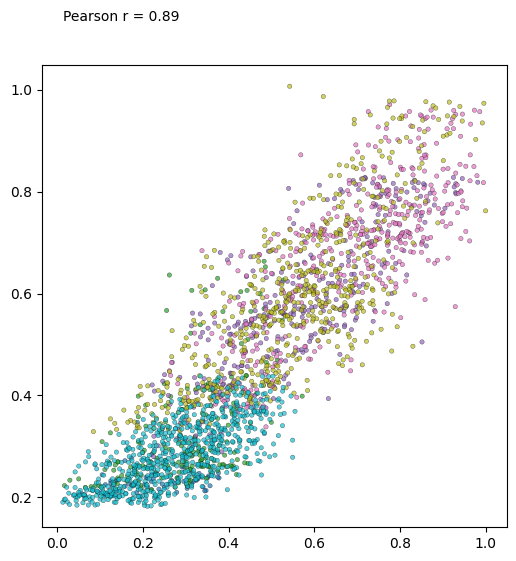

In [43]:
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams['figure.dpi'] = 100
y = sim_data.y
sns.scatterplot(
    x=y.reshape(-1), 
    y=y_pred.reshape(-1), s=10, 
    c=sim_data.adata.obs['sim_cluster'].values[:], cmap=cmap, edgecolor='black', linewidth=0.25, alpha=0.7)

corr, _ = pearsonr(y.reshape(-1), y_pred.reshape(-1))
plt.text(
    x=y.min(), 
    y=y_pred.max()+0.15, 
    s=f'Pearson r = {corr:.2f}', 
    fontsize=10, 
    fontname='DejaVu Sans',
    ha='left',
    va='top'
)
plt.show()

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

vmin = min(np.min(sim_data.y), np.min(y_pred))
vmax = max(np.max(sim_data.y), np.max(y_pred))

sc1 = axes[0].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[0].set_title("Simulated data y")

sc2 = axes[1].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[1].set_title("y pred")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

In [45]:
cool_cluster = 2
indices = np.argwhere(sim_data.labels == cool_cluster).flatten()
plt.scatter(sim_data.xy[:, 0][indices], sim_data.xy[:, 1][indices], c=sim_data.y[indices], s=10)
_ = plt.title(f'y_pred for cluster {cool_cluster}')

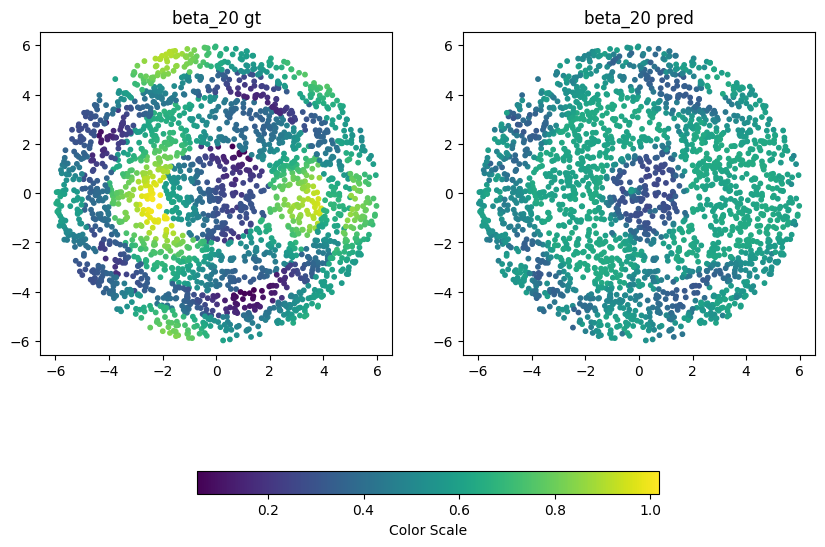

In [46]:
hot_beta = 20

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
vmin = np.min(sim_data.betas[:, hot_beta])
vmax = np.max(sim_data.betas[:, hot_beta])

sc1 = axes[0].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.betas[:, hot_beta], vmin=vmin, vmax=vmax, s=10)
axes[0].set_title(f"beta_{hot_beta} gt")

sc2 = axes[1].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=beta_pred[:, hot_beta], vmin=vmin, vmax=vmax, s=10)
axes[1].set_title(f"beta_{hot_beta} pred")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

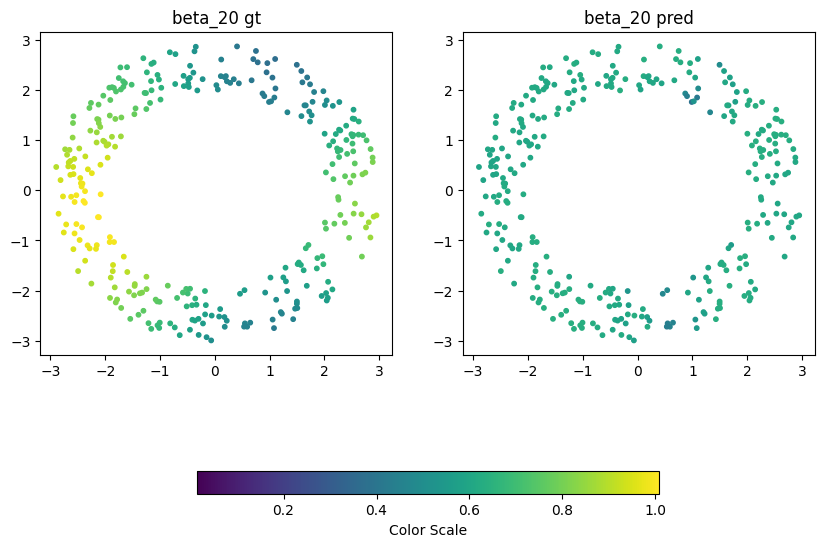

In [47]:
hot_beta = 20
cool_cluster = 2
indices = np.argwhere(sim_data.labels == cool_cluster).flatten()

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
vmin = min(np.min(sim_data.y), np.min(y_pred))
vmax = max(np.max(sim_data.y), np.max(y_pred))

sc1 = axes[0].scatter(sim_data.xy[:, 0][indices], sim_data.xy[:, 1][indices], 
                    c=sim_data.betas[:, hot_beta][indices], vmin=vmin, vmax=vmax, s=10)
axes[0].set_title(f"beta_{hot_beta} gt")

sc2 = axes[1].scatter(sim_data.xy[:, 0][indices], sim_data.xy[:, 1][indices], 
                    c=beta_pred[:, hot_beta][indices], vmin=vmin, vmax=vmax, s=10)
axes[1].set_title(f"beta_{hot_beta} pred")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

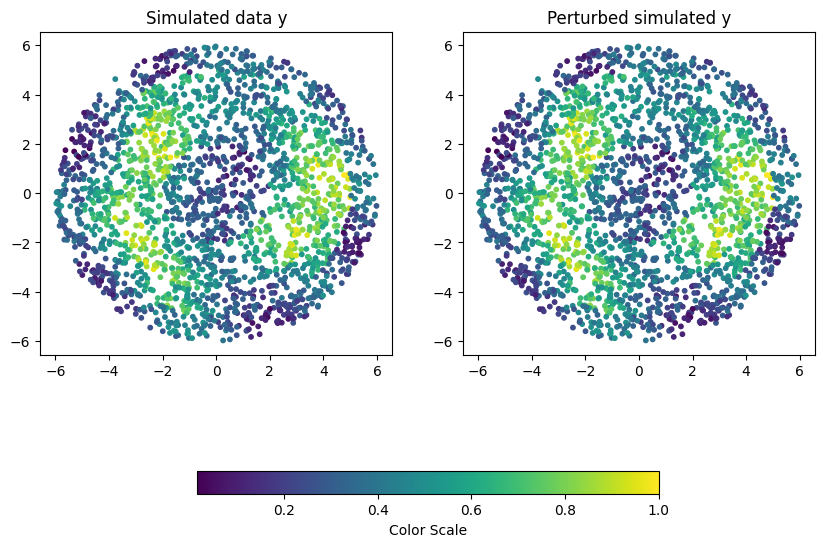

In [48]:
# Simulate KO

tf_ko = 'tf_20'
psim_data = check_betas.perturb(sim_data, tf_ko)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
vmin = min(np.min(psim_data.y), np.min(sim_data.y))
vmax = max(np.max(psim_data.y), np.max(sim_data.y))

sc1 = axes[0].scatter(psim_data.xy[:, 0], psim_data.xy[:, 1], c=sim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[0].set_title("Simulated data y")

sc2 = axes[1].scatter(psim_data.xy[:, 0], psim_data.xy[:, 1], c=psim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[1].set_title("Perturbed simulated y")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

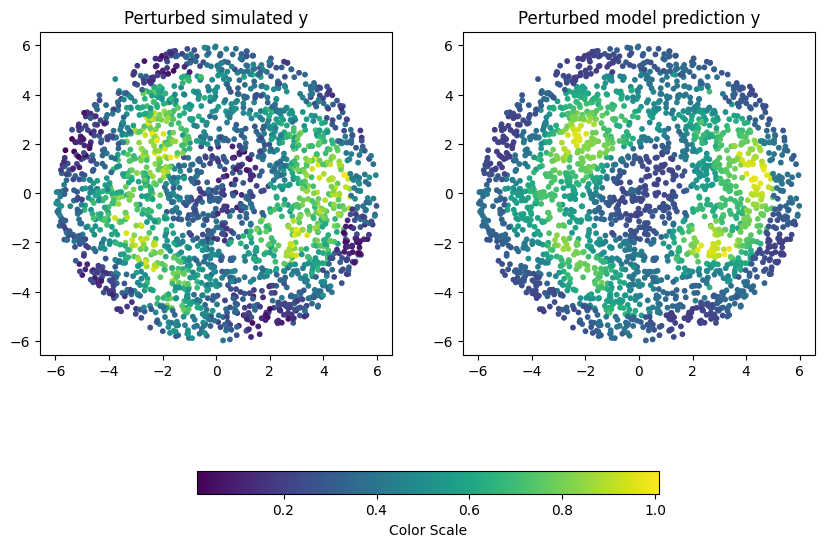

In [49]:
# Model prediction of KO

py_pred = estimator.predict_y(
        estimator.model, 
        torch.from_numpy(beta_pred).cuda(), 
        torch.from_numpy(psim_data.adata.to_df()[estimator.regulators].values).cuda()).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

vmin = min(np.min(py_pred), np.min(psim_data.y))
vmax = max(np.max(py_pred), np.max(psim_data.y))

sc1 = axes[0].scatter(psim_data.xy[:, 0], psim_data.xy[:, 1], c=psim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[0].set_title("Perturbed simulated y")

sc2 = axes[1].scatter(psim_data.xy[:, 0], psim_data.xy[:, 1], c=py_pred, vmin=vmin, vmax=vmax, s=10)
axes[1].set_title("Perturbed model prediction y")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

In [53]:
# Simulated Data pt2

sim_data = SimulatedDataV2(density=10, ntfs=20, clusters=6, position='wave')
estimator = ViTEstimatorV2(sim_data.adata, target_gene='target_gene', 
                        regulators=sim_data.tf_labels, n_clusters=sim_data.clusters)

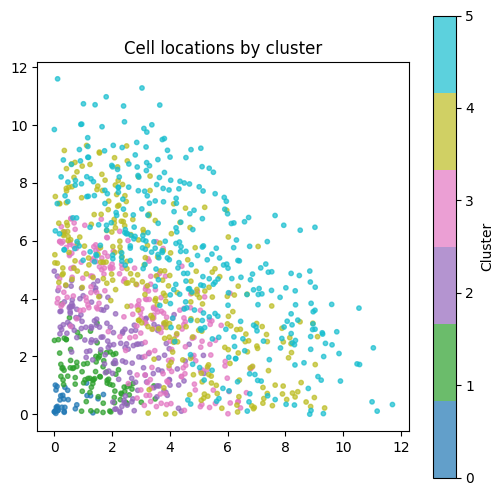

In [54]:
plt.figure(figsize=(6,6))

cmap = mcolors.ListedColormap(plt.cm.get_cmap('tab10', sim_data.clusters).colors)
scatter = plt.scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.labels, cmap=cmap, s=10, alpha=0.7)

plt.colorbar(scatter, label="Cluster")

plt.title('Cell locations by cluster')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()


[cuda] MSE: 0.0357 | Baseline: 3.7167: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]

Best model at 46/100


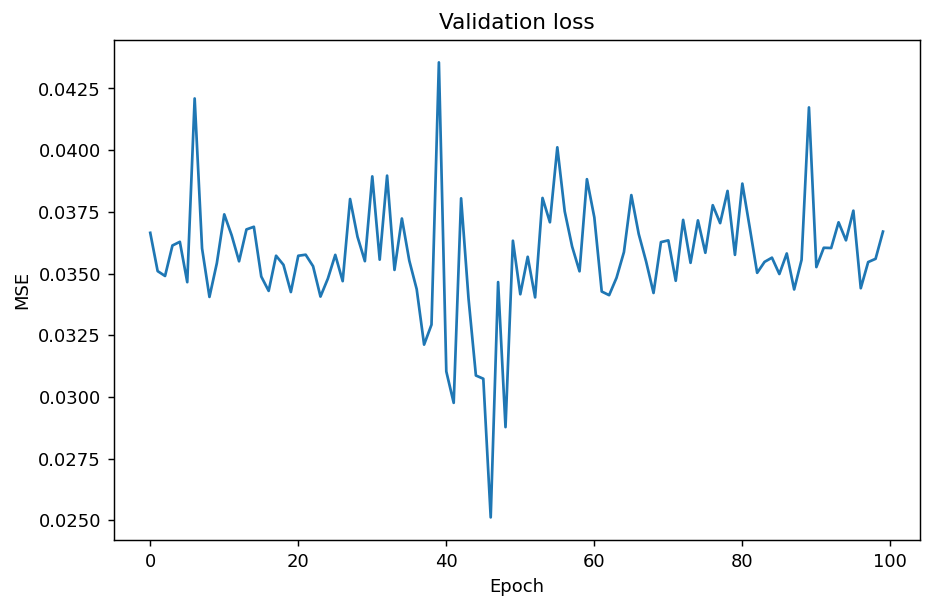

In [55]:
estimator.fit(
    annot='sim_cluster', 
    max_epochs=100, 
    learning_rate=0.01, 
    spatial_dim=64,
    batch_size=32,
    init_betas='ones',
    mode='train_test',
    rotate_maps=True,
    regularize=False,
    n_patches=16, n_heads=2, n_blocks=2, hidden_d=16
)

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams['figure.dpi'] = 130
plt.plot(estimator.losses)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Validation loss')
plt.show()

In [56]:
check_betas = SimulationBetaCallbackV2()

with torch.no_grad():
    beta_pred = estimator.get_betas(
        np.array(sim_data.adata.obsm['spatial']),
        np.array(sim_data.adata.obs['sim_cluster']),
    )

    y_pred = estimator.predict_y(
        estimator.model, 
        torch.from_numpy(beta_pred).cuda(), 
        torch.from_numpy(sim_data.adata.to_df()[estimator.regulators].values).cuda()).cpu().numpy()

check_betas(beta_pred, sim_data.betas)

{'beta0': -0.003802696920960447,
 'beta1': 0.5646095899325574,
 'beta2': 0.5628920152113528,
 'beta3': 0.5616765047187188,
 'beta4': 0.5637419178264447,
 'beta5': 0.55558434807265,
 'beta6': 0.562544797996855,
 'beta7': 0.5521330667728496,
 'beta8': 0.5612626746936639,
 'beta9': 0.554493812434451,
 'beta10': 0.5585218136214207,
 'beta11': 0.5619879357834188,
 'beta12': 0.529588055149744,
 'beta13': 0.5630982865468355,
 'beta14': 0.559883821269375,
 'beta15': 0.5647465491676228,
 'beta16': 0.5595999068880599,
 'beta17': 0.5608960581753164,
 'beta18': 0.5603603413406959,
 'beta19': 0.36199105150005445,
 'beta20': 0.5609370683712914}

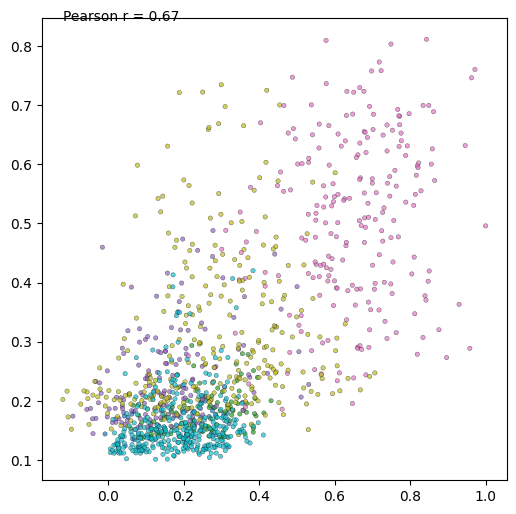

In [61]:
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams['figure.dpi'] = 100
y = sim_data.y
sns.scatterplot(
    x=y.reshape(-1), 
    y=y_pred.reshape(-1), s=10, 
    c=sim_data.adata.obs['sim_cluster'].values[:], cmap=cmap, edgecolor='black', linewidth=0.25, alpha=0.7)

corr, _ = pearsonr(y.reshape(-1), y_pred.reshape(-1))
plt.text(
    x=y.min(), 
    y=y_pred.max()+0.05, 
    s=f'Pearson r = {corr:.2f}', 
    fontsize=10, 
    fontname='DejaVu Sans',
    ha='left',
    va='top'
)
plt.show()

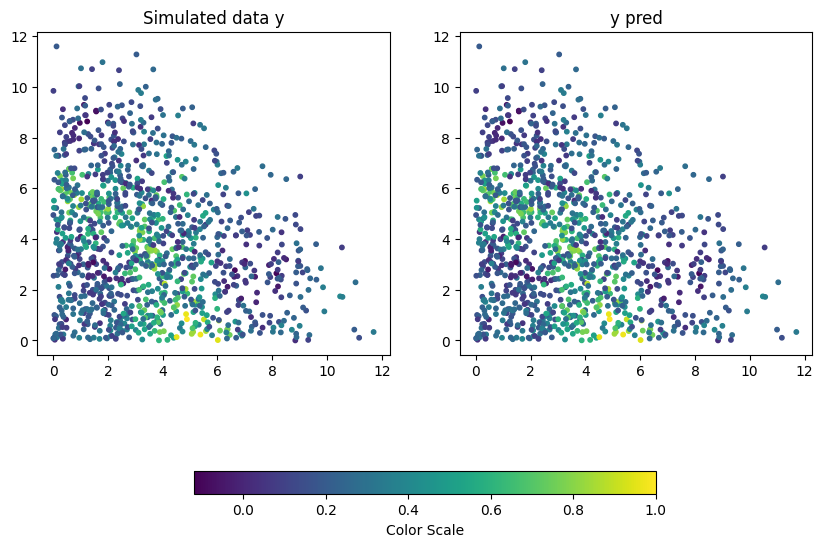

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

vmin = min(np.min(sim_data.y), np.min(y_pred))
vmax = max(np.max(sim_data.y), np.max(y_pred))

sc1 = axes[0].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[0].set_title("Simulated data y")

sc2 = axes[1].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[1].set_title("y pred")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

In [63]:
cool_cluster = 2
indices = np.argwhere(sim_data.labels == cool_cluster).flatten()
plt.scatter(sim_data.xy[:, 0][indices], sim_data.xy[:, 1][indices], c=sim_data.y[indices], s=10)
_ = plt.title(f'y_pred for cluster {cool_cluster}')

In [64]:
hot_beta = 19

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
vmin = min(np.min(sim_data.y), np.min(y_pred))
vmax = max(np.max(sim_data.y), np.max(y_pred))

sc1 = axes[0].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.betas[:, hot_beta], vmin=vmin, vmax=vmax, s=10)
axes[0].set_title(f"beta_{hot_beta} gt")

sc2 = axes[1].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=beta_pred[:, hot_beta], vmin=vmin, vmax=vmax, s=10)
axes[1].set_title(f"beta_{hot_beta} pred")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

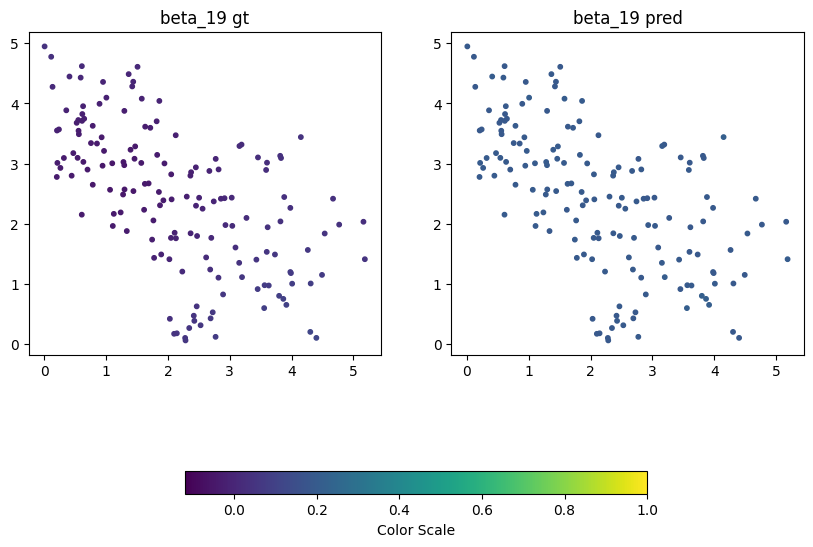

In [65]:
hot_beta = 19
cool_cluster = 2
indices = np.argwhere(sim_data.labels == cool_cluster).flatten()

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
vmin = min(np.min(sim_data.y), np.min(y_pred))
vmax = max(np.max(sim_data.y), np.max(y_pred))

sc1 = axes[0].scatter(sim_data.xy[:, 0][indices], sim_data.xy[:, 1][indices], 
                    c=sim_data.betas[:, hot_beta][indices], vmin=vmin, vmax=vmax, s=10)
axes[0].set_title(f"beta_{hot_beta} gt")

sc2 = axes[1].scatter(sim_data.xy[:, 0][indices], sim_data.xy[:, 1][indices], 
                    c=beta_pred[:, hot_beta][indices], vmin=vmin, vmax=vmax, s=10)
axes[1].set_title(f"beta_{hot_beta} pred")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

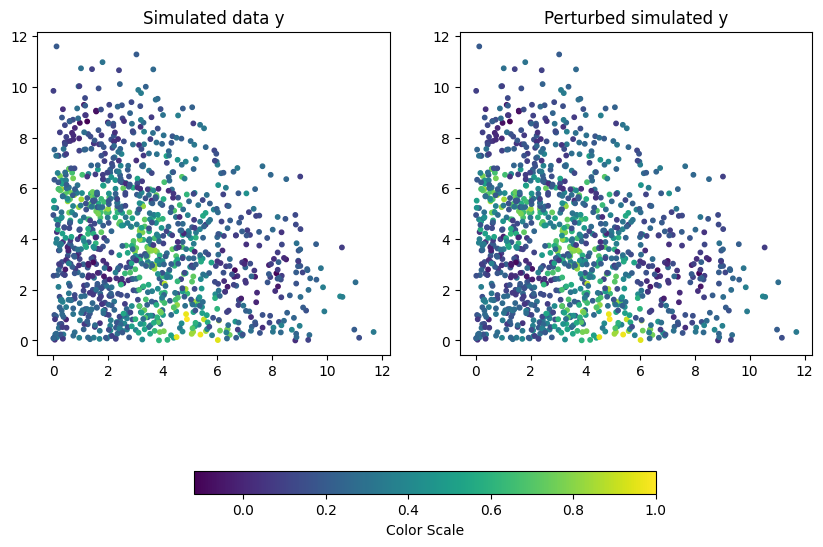

In [66]:
# Simulate KO

tf_ko = 'tf_18'
psim_data = check_betas.perturb(sim_data, tf_ko)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
vmin = min(np.min(psim_data.y), np.min(sim_data.y))
vmax = max(np.max(psim_data.y), np.max(sim_data.y))

sc1 = axes[0].scatter(psim_data.xy[:, 0], psim_data.xy[:, 1], c=sim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[0].set_title("Simulated data y")

sc2 = axes[1].scatter(psim_data.xy[:, 0], psim_data.xy[:, 1], c=psim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[1].set_title("Perturbed simulated y")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

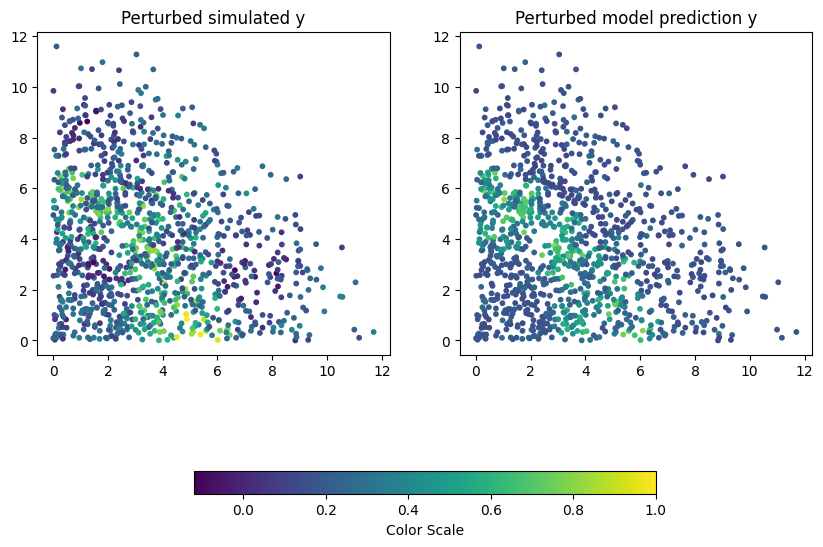

In [67]:
# Model prediction of KO

py_pred = estimator.predict_y(
        estimator.model, 
        torch.from_numpy(beta_pred).cuda(), 
        torch.from_numpy(psim_data.adata.to_df()[estimator.regulators].values).cuda()).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

vmin = min(np.min(py_pred), np.min(psim_data.y))
vmax = max(np.max(py_pred), np.max(psim_data.y))

sc1 = axes[0].scatter(psim_data.xy[:, 0], psim_data.xy[:, 1], c=psim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[0].set_title("Perturbed simulated y")

sc2 = axes[1].scatter(psim_data.xy[:, 0], psim_data.xy[:, 1], c=py_pred, vmin=vmin, vmax=vmax, s=10)
axes[1].set_title("Perturbed model prediction y")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()